# Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification
---
**Author:** Yash Purswani\
**Roll Number:** ME22B214

## Objective:

The objective of this assignment is to deepen our understanding of the challenges in **real-world multi-label classification**, by applying advanced non-linear dimensionality reduction techniques **t-SNE** and **Isomap** to the Yeast dataset.  

Through these visualizations, we aim to **inspect data veracity issues** such as:
- **Noisy or ambiguous labels**: genes whose functions span multiple categories or are misclassified,
- **Outliers**: experiments with highly unusual gene expression profiles,
- **Hard-to-learn samples**: data points that lie in regions where functional categories are thoroughly mixed.

This biological context encourages us to think critically about **data quality challenges** and their impact on machine learning models.


The dataset is taken from [MULAN Repository - Yeast Dataset](http://sourceforge.net/projects/mulan/files/datasets/yeast.rar).

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

## Part A: Data Preprocessing

### Loading the dataset
This cell tries to load `yeast/yeast-train.arff`. It attempts to use `scipy.io.arff` to load the dataset into a dataframe for pre-processing.

In [3]:
# Path to ARFF file (update if needed)
arff_path = 'yeast/yeast.arff'  # <= change this if your file is somewhere else

def load_arff_to_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"ARFF file not found at: {path}")
    try:
        from scipy.io import arff as scipy_arff
        data, meta = scipy_arff.loadarff(path)
        df = pd.DataFrame(data)
        # decode bytes to str for object columns
        for c in df.select_dtypes([object]).columns:
            df[c] = df[c].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
        return df
    except Exception as e2:
        raise RuntimeError("Failed to load ARFF with scipy.io.arff. Error: " + str(e2))

# Load
df_raw = load_arff_to_df(arff_path)
print('Loaded ARFF into DataFrame with shape:', df_raw.shape)
df_raw.head()

Loaded ARFF into DataFrame with shape: (2417, 117)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [4]:
# Descriptive stats
df_raw.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,-0.000773,0.000464,-0.000515,0.000667,0.000324,-0.001483,-0.001047,-0.001539,0.000284,0.007605
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.093316,0.096684,0.096209,0.096635,0.096280,0.094369,0.096900,0.094211,0.093154,0.099368
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,-0.455191,-0.283594,-0.279408,-0.226420,-0.225374,-0.501572,-0.236589,-0.267052,-0.194079,-0.237752
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,-0.054133,-0.056415,-0.056414,-0.059382,-0.058025,-0.053591,-0.063318,-0.059542,-0.054078,-0.077191
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,-0.012893,-0.023595,-0.024313,-0.023059,-0.021942,-0.018216,-0.033623,-0.023519,-0.012007,0.022126
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,0.027977,0.034937,0.036057,0.041430,0.035730,0.019583,0.038901,0.025408,0.028087,0.103185
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,0.609175,0.542867,0.547134,0.385928,0.540493,0.569250,0.509963,0.587358,0.700340,0.163431


The attributes of the data appear to be normalized as mean is 0.

### Dimensionality check

This section reports the number of data points and features, and attempts to detect label columns (binary columns with values 0/1).

In [5]:
# Identify binary columns (likely label columns) and numeric feature columns
# Heuristic: label columns contain only {0,1} or {b'0', b'1'}
binary_cols = [c for c in df_raw.columns if set(pd.unique(df_raw[c]).tolist()) <= {0,1,'0','1'}]
# Numeric feature columns: those that are numeric and not identified as label columns
numeric_cols = [c for c in df_raw.columns if c not in binary_cols and pd.api.types.is_numeric_dtype(df_raw[c])]
print("Total instances:", len(df_raw))
print("Detected numeric feature columns:", len(numeric_cols))
print("Detected binary (candidate label) columns:", len(binary_cols))
print("\nSample of detected label columns", binary_cols)

Total instances: 2417
Detected numeric feature columns: 103
Detected binary (candidate label) columns: 14

Sample of detected label columns ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']


### Create feature matrix X and multi-label matrix Y

We will use the detected numeric columns as `X` and the binary columns as `Y`.

In [6]:
# Build X and Y using heuristics above
X = df_raw[numeric_cols].astype(float).copy()
Y = df_raw[binary_cols].astype(int).copy() if len(binary_cols)>0 else pd.DataFrame()
print('X shape:', X.shape)
print('Y shape:', Y.shape)
# show first rows
display(X.head())
display(Y.head())

X shape: (2417, 103)
Y shape: (2417, 14)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,-0.083809,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,-0.060467,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


### Label selection for visualization

We will create a simplified categorical target for coloring: the two most frequent single-label classes (instances where exactly one label is active) and the most frequent multi-label combination. All other samples are labeled 'Other'. This reduces confusion in plots while keeping meaningful groups.

In [34]:
# Build simplified categorical target as specified in the assignment
def create_visual_labels(Y):
    # compute rows with exactly one label
    single_label_rows = Y.sum(axis=1) == 1
    single_label_names = []
    for col in Y.columns:
        count_single = int(((Y[col]==1) & single_label_rows).sum())
        single_label_names.append((col, count_single))

    # top two most frequent single-label classes
    single_label_names.sort(key=lambda x: x[1], reverse=True)
    top_two_single = [name for name,count in single_label_names[:2] if count>0]
    # find most frequent multi-label combination (as tuple)
    combos = Y.apply(lambda row: tuple(np.where(row.values==1)[0].tolist()), axis=1)
    combo_counts = Counter(combos)
    # remove singletons (we already handled them)
    multi_combo_counts = {combo:cnt for combo,cnt in combo_counts.items() if len(combo)>1}
    most_freq_multi = None
    if len(multi_combo_counts)>0:
        most_freq_multi = max(multi_combo_counts.items(), key=lambda x: x[1])[0]
    # create category per row
    cats = []
    for i,row in Y.iterrows():
        labels_idx = tuple(np.where(row.values==1)[0].tolist())
        if len(labels_idx)==1 and Y.columns[labels_idx[0]] in top_two_single:
            cats.append("MostFreqSingle")
        elif len(labels_idx)>1 and tuple(labels_idx)==most_freq_multi:
            cats.append("MultiCombo")
        else:
            cats.append("Other")
    return pd.Series(cats, name='vis_label')

vis_label = create_visual_labels(Y)
print("Category counts:\n", vis_label.value_counts())

Category counts:
 vis_label
Other             2148
MultiCombo         237
MostFreqSingle      32
Name: count, dtype: int64


### Scaling

Distance-based DR techniques rely on pairwise distances; features on different scales distort those distances. We standardize to zero mean and unit variance.

Now scale `X` with `StandardScaler` as it is resiliant to outliers.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled X shape:", X_scaled.shape)

Scaled X shape: (2417, 103)


In [10]:
X.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,-0.000773,0.000464,-0.000515,0.000667,0.000324,-0.001483,-0.001047,-0.001539,0.000284,0.007605
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.093316,0.096684,0.096209,0.096635,0.096280,0.094369,0.096900,0.094211,0.093154,0.099368
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,-0.455191,-0.283594,-0.279408,-0.226420,-0.225374,-0.501572,-0.236589,-0.267052,-0.194079,-0.237752
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,-0.054133,-0.056415,-0.056414,-0.059382,-0.058025,-0.053591,-0.063318,-0.059542,-0.054078,-0.077191
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,-0.012893,-0.023595,-0.024313,-0.023059,-0.021942,-0.018216,-0.033623,-0.023519,-0.012007,0.022126
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,0.027977,0.034937,0.036057,0.041430,0.035730,0.019583,0.038901,0.025408,0.028087,0.103185
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,0.609175,0.542867,0.547134,0.385928,0.540493,0.569250,0.509963,0.587358,0.700340,0.163431


## Part B: t-SNE and Veracity Inspection

### t-SNE Implementation
We'll compute t-SNE for multiple perplexities (5, 10, 20, 30, 40, 50) and show how the embedding changes. Then we'll pick a final perplexity and analyze veracity issues.

Computed t-SNE with perplexity=5, shape (2417, 2)
Computed t-SNE with perplexity=10, shape (2417, 2)
Computed t-SNE with perplexity=20, shape (2417, 2)
Computed t-SNE with perplexity=30, shape (2417, 2)
Computed t-SNE with perplexity=40, shape (2417, 2)
Computed t-SNE with perplexity=50, shape (2417, 2)
Computed t-SNE with perplexity=60, shape (2417, 2)


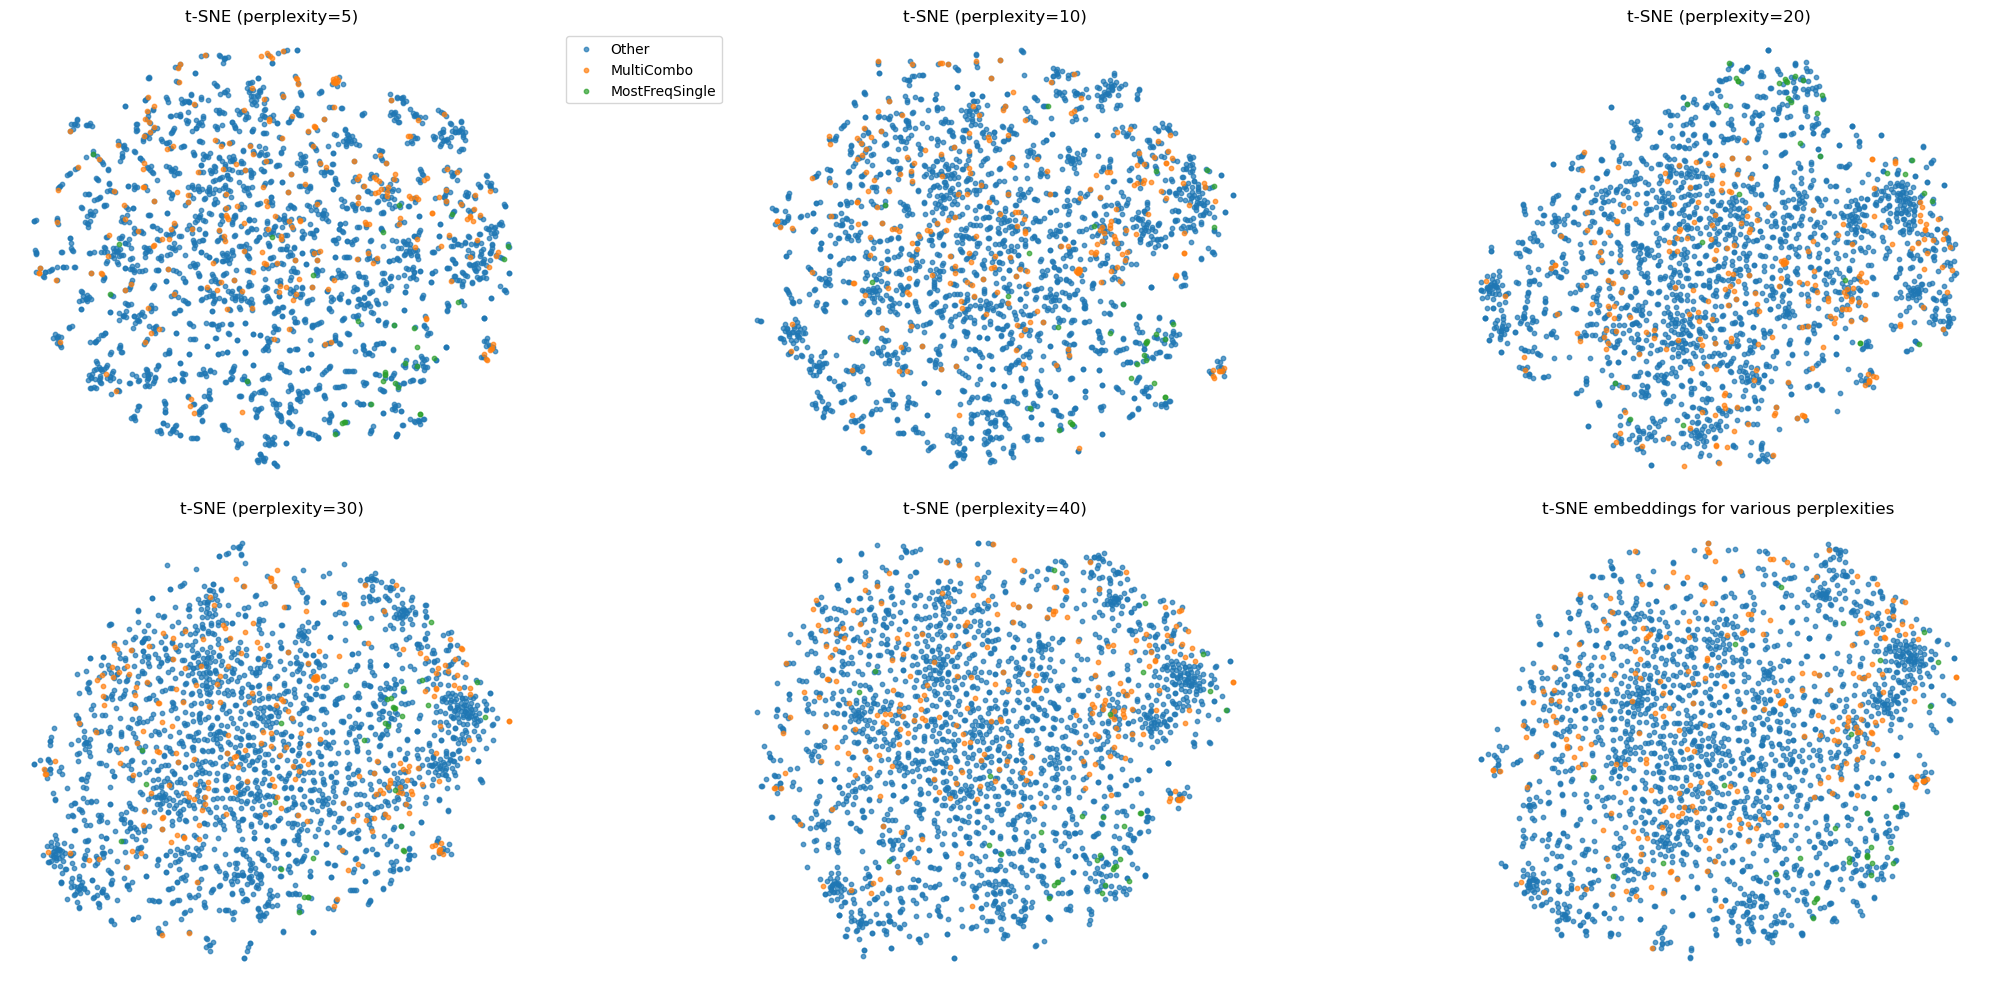

In [ ]:
# Run t-SNE for a few perplexities and plot
perplexities = [5, 10, 20, 30, 40, 50, 60]
tsne_results = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    emb = tsne.fit_transform(X_scaled)
    tsne_results[p] = emb
    print(f"Computed t-SNE with perplexity={p}, shape {emb.shape}")

# Plotting the three results side-by-side
n = 2
fig, axes = plt.subplots(n, len(perplexities)//n, figsize=(20,10))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
for ax,p in zip(axes,perplexities):
    emb = tsne_results[p]
    for cat in vis_label.unique():
        mask = (vis_label==cat).values
        ax.scatter(emb[mask,0], emb[mask,1], s=10, label=str(cat), alpha=0.7)
    ax.set_title(f"t-SNE (perplexity={p})")
    ax.axis('off')
axes[0].legend(loc='best', bbox_to_anchor=(1.05,1))
fig.suptitle("t-SNE embeddings for various perplexities", fontsize=20)
plt.tight_layout()
plt.show()

### Selection of Optimal Perplexity

The **perplexity** parameter in t-SNE controls the balance between local and global structure in the embedding.  
To determine a suitable value, we experimented with perplexities of **5, 10, 20, 30, 40 and 50**, and compared the resulting plots.  

- **Cluster Separation:**  
  - At very low perplexity (5), the embedding fragmented into many small, scattered clusters, losing the overall structure.  
  - At high perplexity (50), clusters overlapped significantly, making it harder to interpret the categories.  
  - At perplexity **40**, clusters were well-separated and interpretable, showing a balance between local neighborhood preservation and global arrangement.  

- **Cluster Shape and Stability:**  
  - At 40, the clusters appeared **well-defined and reproducible**, rather than noisy clouds or overly compressed groups.  
  - This makes it easier to identify outliers, noisy labels, and regions with mixed categories.  

**Final Choice:** We select **perplexity = 40** as the optimal value since it produces the clearest and most interpretable visualization for this dataset.


### Final t-SNE visualization (perplexity = 40)

We'll use `perplexity=40` as the final embedding and create a clearer plot. Then we'll algorithmically flag noisy/ambiguous samples, outliers, and hard-to-learn areas using neighborhood statistics in the embedding space.

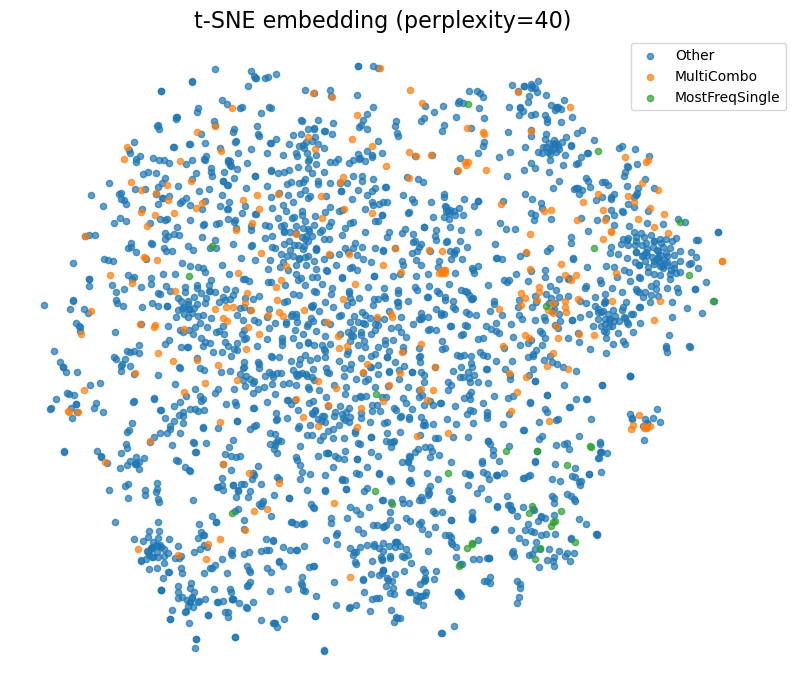

In [55]:
final_p = 40
emb = tsne_results[final_p]

# Plot final embedding
fig, ax = plt.subplots(figsize=(8,7))
unique_cats = list(vis_label.unique())
for cat in unique_cats:
    mask = (vis_label==cat).values
    ax.scatter(emb[mask,0], emb[mask,1], s=20, label=str(cat), alpha=0.7)
ax.set_title("t-SNE embedding (perplexity=40)", fontsize=16)
ax.axis('off')
ax.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

### Veracity Inspection

- **Noisy/Ambiguous labels:** Points whose k nearest neighbors in the embedding are mostly of a different category (we mark those where >60% neighbors differ).
- **Outliers:** Points whose distance to the embedding centroid is > 3 standard deviations.
- **Hard-to-learn samples:** Points whose neighborhood contains a high diversity of labels (Shannon entropy > 1.0 in neighbor labels).

These are heuristic rules for visual identification; they help surface suspicious points for manual inspection.

Detected counts -> outliers: 3 , noisy: 269 , hard-to-learn: 31


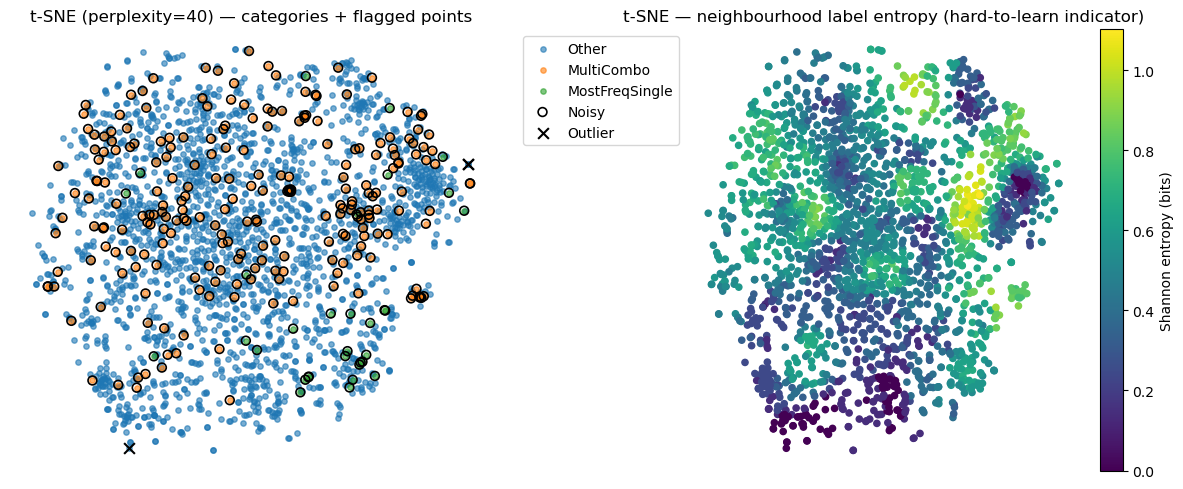

In [86]:
# Compute neighbors in embedding space
k = 50
nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(emb)  # +1 because the point itself is included
distances, indices = nn.kneighbors(emb)

# For each point, compute fraction of neighbors with same vis_label
fractions_same = []
label_entropy = []
for i in range(len(emb)):
    neigh_idx = indices[i,1:]  # exclude itself at position 0
    neigh_labels = vis_label.iloc[neigh_idx].values
    same_frac = np.mean(neigh_labels == vis_label.iloc[i])
    fractions_same.append(same_frac)
    # label distribution entropy
    counts = Counter(neigh_labels)
    probs = np.array(list(counts.values()))/np.sum(list(counts.values()))
    # shannon entropy
    entropy = -np.sum(probs * np.log2(probs+1e-12))
    label_entropy.append(entropy)

fractions_same = np.array(fractions_same)
label_entropy = np.array(label_entropy)

# Outliers by distance from centroid
centroid = emb.mean(axis=0)
dists = np.linalg.norm(emb - centroid, axis=1)
outlier_mask = dists > (dists.mean() + 2*dists.std())

# Noisy mask
noisy_mask = fractions_same < 0.4  # <40% same class among neighbors
# Hard-to-learn mask
hard_mask = label_entropy > 1.0

print("Detected counts -> outliers:", outlier_mask.sum(), ", noisy:", noisy_mask.sum(), ", hard-to-learn:", hard_mask.sum())

# Plot embedding with these markings
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax0, ax1 = ax
for cat in unique_cats:
    mask = (vis_label==cat).values
    ax0.scatter(emb[mask,0], emb[mask,1], s=15, label=str(cat), alpha=0.6)
# overlay noisy points
ax0.scatter(emb[noisy_mask,0], emb[noisy_mask,1], s=40, facecolors='none', edgecolors='k', linewidths=1.2, label='Noisy')
ax0.scatter(emb[outlier_mask,0], emb[outlier_mask,1], s=60, marker='x', c='k', label='Outlier')
ax0.set_title('t-SNE (perplexity=40) — categories + flagged points')
ax0.axis('off')
ax0.legend(bbox_to_anchor=(1.05,1))

# Right plot: show hard-to-learn area intensity
sc = ax1.scatter(emb[:,0], emb[:,1], c=label_entropy, s=20)
ax1.set_title('t-SNE — neighbourhood label entropy (hard-to-learn indicator)')
ax1.axis('off')
plt.colorbar(sc, ax=ax1, label='Shannon entropy (bits)')
plt.tight_layout()
plt.show()

### Veracity Inspection Results

From our heuristic analysis of the t-SNE embedding we draw the following interpretations:

- **Noisy / Ambiguous Labels:** 

  The 269 points flagged as noisy are those that lie in neighborhoods dominated by other categories. In the scatter plot, these points appear as *miscolored dots embedded within a cluster of a different class*.  
  This suggests possible **labeling ambiguity** (e.g., genes whose functions span multiple categories) or **labeling errors** in the dataset.

- **Outliers:**  

  The 3 outliers are isolated points.
  These may represent **unusual gene expression profiles**, potentially caused by experimental error, rare biological processes, or extreme measurement conditions.  
  Outliers are important to identify since they can disproportionately affect models if not handled properly.

- **Hard-to-Learn Samples:**  

  The 52 samples flagged as hard-to-learn are located in regions where different functional categories are thoroughly mixed, as shown by high neighborhood label entropy.  
  A simple classifier would likely struggle here because there is no clear separation boundary between categories — the decision surface would need to be highly non-linear and complex.

## Part C:  Isomap and Manifold Learning

We compute a 2D Isomap embedding and compare it to t-SNE.

### Fundamental Difference Between Isomap and t-SNE

- **Isomap** preserves the **global structure** of the data by approximating geodesic distances along the manifold.  
  - It builds a nearest-neighbor graph and computes shortest paths, capturing how points are arranged in the larger space.  
  - Good for revealing the **overall geometry** and continuous structure of the dataset.

- **t-SNE** preserves the **local structure** by focusing on pairwise similarities (probability distributions of neighbors).  
  - It emphasizes keeping nearby points close together, often producing well-separated local clusters.  
  - Good for visualizing **fine-grained clusters**, but it may distort global distances between them.

In [90]:
# Run Isomap
n_neighbors = 20
iso = Isomap(n_components=2, n_neighbors=n_neighbors)
iso_emb = iso.fit_transform(X_scaled)
print("Isomap embedding shape:", iso_emb.shape)

Isomap embedding shape: (2417, 2)


### Isomap Visualization

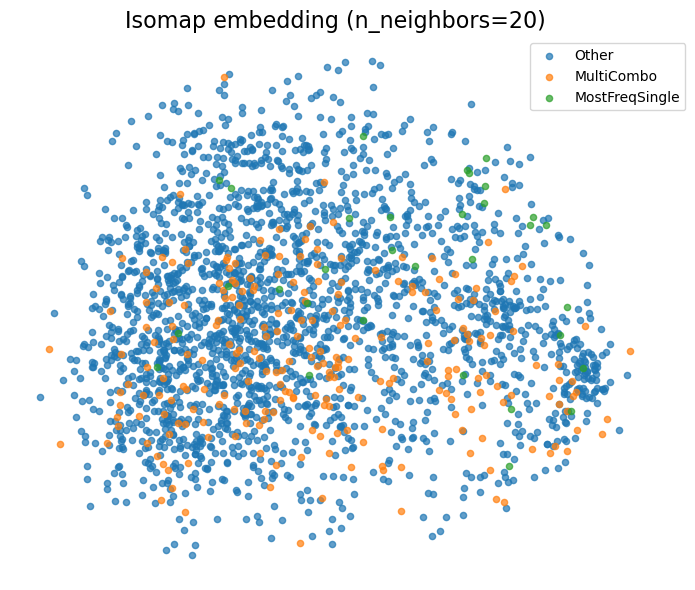

In [91]:
# Plot Isomap embedding with same coloring
fig, ax = plt.subplots(figsize=(7,6))
for cat in unique_cats:
    mask = (vis_label==cat).values
    ax.scatter(iso_emb[mask,0], iso_emb[mask,1], s=20, label=str(cat), alpha=0.7)
ax.set_title(f'Isomap embedding (n_neighbors={n_neighbors})', fontsize=16)
ax.axis('off')
ax.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

### Comparison & manifold curvature discussion

- **Which shows global structure better?** Isomap attempts to preserve global manifold geometry; if clusters in Isomap appear arranged to reflect relative positions while t-SNE shows separated islands that may not reflect true global distances, Isomap is likely better at revealing global structure.

- **Manifold complexity:** If Isomap embedding exhibits smooth elongated shapes and gradual curvature, that suggests a manifold with moderate curvature. Highly twisted or fragmented Isomap plots imply a complex manifold, making classification harder because labels may be interleaved along the manifold.